In [432]:
import networkx as nx # the main libary we will use
from networkx.algorithms import bipartite
from networkx.algorithms import community, centrality
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline 
from datetime import datetime, timedelta
from datetime import date
import powerlaw
from collections import defaultdict, Counter
from networkx.algorithms import community
from networkx.algorithms import bipartite
from networkx.algorithms import centrality as ce
from networkx.algorithms import community as c
from IPython.display import display, HTML

In [433]:
file= 'data/Investments.xlsx'
df = pd.read_excel(file)

### Preprocess

In [434]:
df = df[['company_name','company_market','investor_name','funded_year','raised_amount_usd']]
df.rename(columns = {'company_name' : 'Company_Name', 'company_market' : 'Company_Market', 'investor_name':'Investor_Name', 'funded_year':'Funded_Year', 'raised_amount_usd':'Raised_Amount_USD'}, inplace = True)
df = df.dropna()
df = df[df.Raised_Amount_USD != 0]
df = df[df.Funded_Year>=1990]

In [435]:
df.head()

,Company_Name,Company_Market,Investor_Name,Funded_Year,Raised_Amount_USD
31,Knowledge Adventure,Games,William Lohse,1990,60000.0
43,Market Wire,Advertising,Hummer Winblad Venture Partners,1990,17550000.0
44,Market Wire,Advertising,Mindful Investors,1990,17550000.0
45,Market Wire,Advertising,Montreux Equity Partners,1990,17550000.0
46,Market Wire,Advertising,Osprey Ventures,1990,17550000.0


### Data exploration

In [436]:
print(f"Number of unique investors: {df['Investor_Name'].nunique()}")
print(f"Number of unique companies: {df['Company_Name'].nunique()}")
print(f"Number of unique company markets: {df['Company_Market'].nunique()}")
print(f"Number of unique years: {df['Funded_Year'].nunique()}")
print(f"Number of investments: {df.shape[0]}")

Number of unique investors: 20156
Number of unique companies: 24908
Number of unique company markets: 695
Number of unique years: 23
Number of investments: 99090


#### Building the network

In [438]:
G_weighted_directed = nx.from_pandas_edgelist(df=df,source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
print('General information about the graph (all data):\n\n',nx.info(G_weighted_directed))

General information about the graph (all data):

 Name: 
Type: MultiDiGraph
Number of nodes: 44777
Number of edges: 99090
Average in degree:   2.2130
Average out degree:   2.2130


#### Split the data by years

In [439]:
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]
years_dict = {i:year_range for i,year_range in enumerate(years_range)}
df_list =[df[(df['Funded_Year'] <= year_range[1]) & (df['Funded_Year'] >= year_range[0])] for year_range in years_range]
graph_list = [nx.from_pandas_edgelist(df_list[i],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph()) for i, _ in enumerate(years_range)]

#### General distributions

   Years     :   Edges   
1990 - 1994  :    15
1995 - 1999  :    233
2000 - 2004  :    1635
2005 - 2009  :    28455
2010 - 2014  :    68752


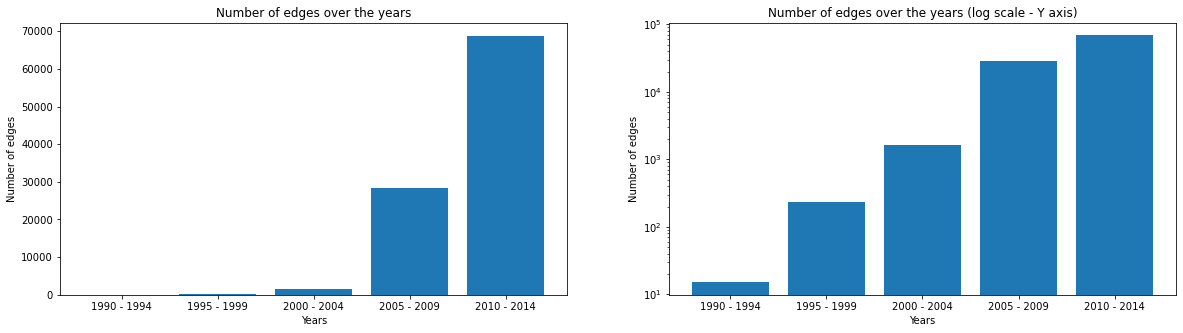

In [443]:
print('   Years     :   Edges   ')
edge_number_histogram = {f'{year_range[0]} - {year_range[1]}':graph_list[i].number_of_edges() for i, year_range  in enumerate(years_range)}
for years,edges in edge_number_histogram.items():
    print(f'{years}  :    {edges}')

fig, axs = plt.subplots(1,2,figsize=(20,5))
for i in range(2):
    axs[i].bar(edge_number_histogram.keys(), edge_number_histogram.values())
    axs[i].set_xlabel("Years")
    axs[i].set_ylabel("Number of edges")
    titel = f'Number of edges over the years'
    if i>0:
        axs[i].set_yscale('log')
        titel += ' (log scale - Y axis)'
    axs[i].set_title(titel)

   Years     :   Nodes   
1990 - 1994  :    21
1995 - 1999  :    256
2000 - 2004  :    1317
2005 - 2009  :    14250
2010 - 2014  :    35122


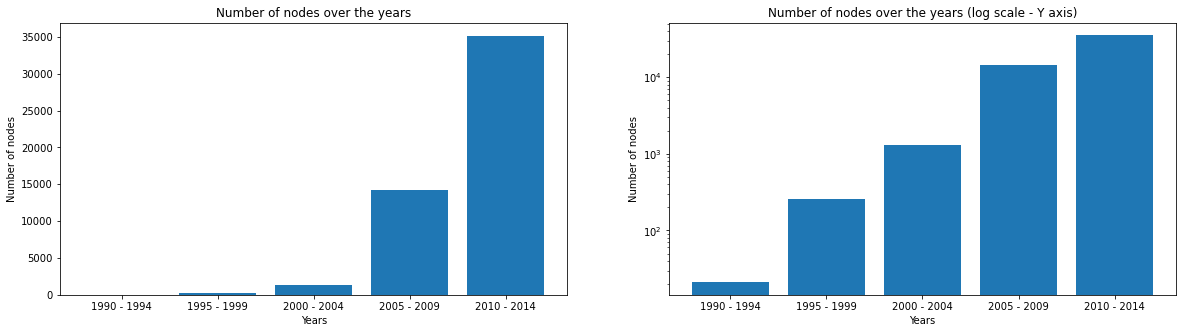

In [444]:
print('   Years     :   Nodes   ')
node_number_histogram = {f'{year_range[0]} - {year_range[1]}':graph_list[i].number_of_nodes() for i, year_range  in enumerate(years_range)}
for years,nodes in node_number_histogram.items():
    print(f'{years}  :    {nodes}')

fig, axs = plt.subplots(1,2,figsize=(20,5))
for i in range(2):
    axs[i].bar(node_number_histogram.keys(), node_number_histogram.values())
    axs[i].set_xlabel("Years")
    axs[i].set_ylabel("Number of nodes")
    titel = f'Number of nodes over the years'
    if i>0:
        axs[i].set_yscale('log')
        titel += ' (log scale - Y axis)'
    axs[i].set_title(titel)

#### Measures, Features and Plotting

Name: 
Type: MultiDiGraph
Number of nodes: 35122
Number of edges: 68752
Average in degree:   1.9575
Average out degree:   1.9575


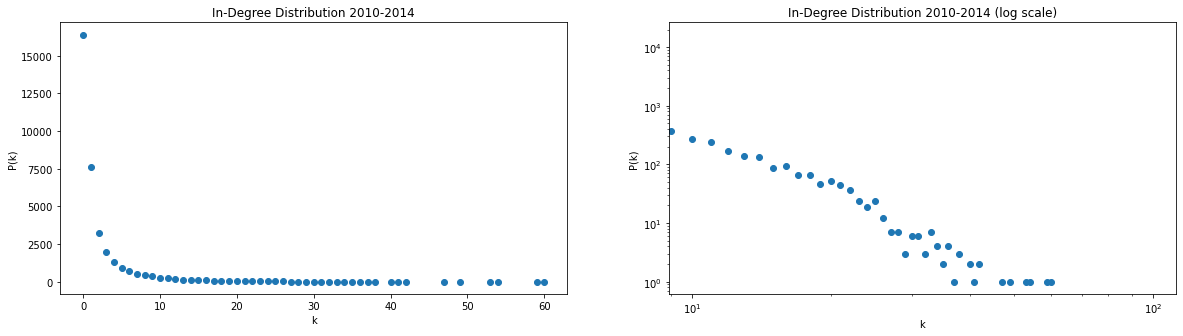

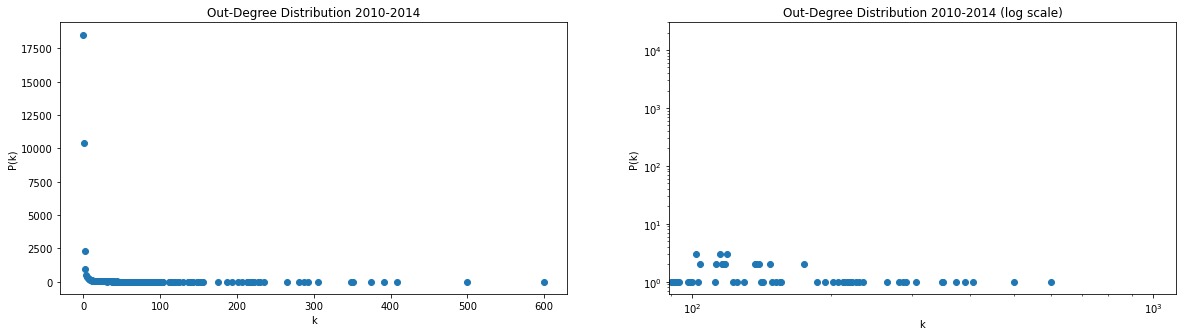

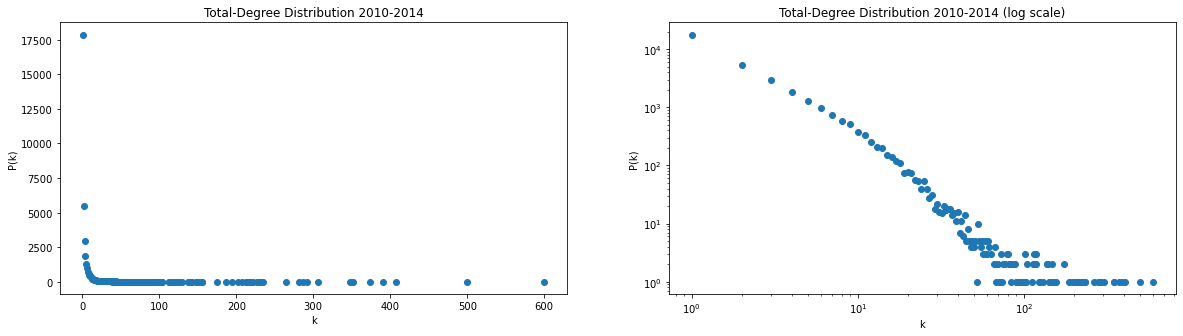

In [413]:
def plot_degree_distribution(num):
    # G_weighted_directed = nx.from_pandas_edgelist(df=df_list[4],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
    G_weighted_directed = graph_list[num]
    # nodes = pd.DataFrame(list(G_weighted_directed.nodes))
    print(nx.info(G_weighted_directed))
    # degrees = [G_weighted_directed.degree(n) for n in G_weighted_directed.nodes()]
    degree_dict = {'In':G_weighted_directed.in_degree,'Out':G_weighted_directed.out_degree,'Total':G_weighted_directed.degree}
    dic = defaultdict() # key=in/out/total : value=count_deg
    for item in degree_dict.items():
        count_deg = defaultdict(int)
        for node, degree in item[1]:
            count_deg[degree] += 1 / len(item[1])
            count_deg[degree] += 1
        dic[item[0]] = count_deg

    for j,dict in dic.items():
        fig, axs = plt.subplots(1,2,figsize=(20,5))
        for i in range(2):
            axs[i].scatter(dict.keys(), dict.values())
            axs[i].set_xlabel("k")
            axs[i].set_ylabel("P(k)")
            titel = f'{j}-Degree Distribution {years_range[4][0]}-{years_range[4][1]}'
            if i>0:
                axs[i].set_yscale('log')
                axs[i].set_xscale('log')
                titel += ' (log scale)'
            axs[i].set_title(titel)

plot_degree_distribution(4)

Calculating best minimal value for power law fit
Gamma (Total)' = 2.7094613035130446


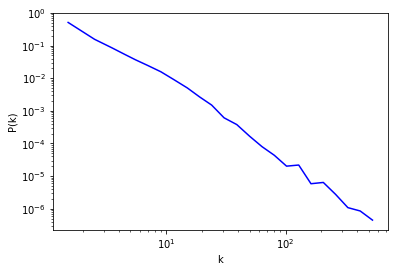

In [406]:
def plot_gamma(num):
    G_weighted_directed = graph_list[num]
    degree_dict = {'In':G_weighted_directed.in_degree,'Out':G_weighted_directed.out_degree,'Total':G_weighted_directed.degree}
    degree_sequence = sorted([d for _, d in degree_dict['Total']],reverse=True)
    figPDF = powerlaw.plot_pdf(degree_sequence,color='b')
    figPDF.set_ylabel(r"P(k)")
    figPDF.set_xlabel(r"k")
    fit = powerlaw.Fit(degree_sequence,discrete=True)
    gamma = fit.power_law.alpha
    print(f"Gamma (Total)' = {gamma}")

plot_gamma(4)

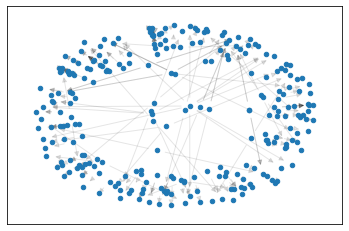

In [393]:
# Plot directional Graph

# G = nx.MultiDiGraph()
# edges = [df_list[3]]
# G = nx.from_pandas_edgelist(df=df_list[1],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
G = graph_list[1]
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 20)
nx.draw_networkx_edges(G,pos,alpha=0.1)
# nx.draw_networkx_labels(G, pos)
plt.show()

In [430]:
def print_giant_component(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.Graph())
    print('v')
    if nx.is_connected(G):
      print("Diameter(G)=",nx.diameter(G))
    else:
        print(f'Graph of years {years_dict[num][0]}-{years_dict[num][1]} is unconnected')
        print("Size giant componenet =", len(max(nx.connected_components(G),key=len)))

print_giant_component(4)

v
Graph of years 2010-2014 is unconnected
Size giant componenet = 28533


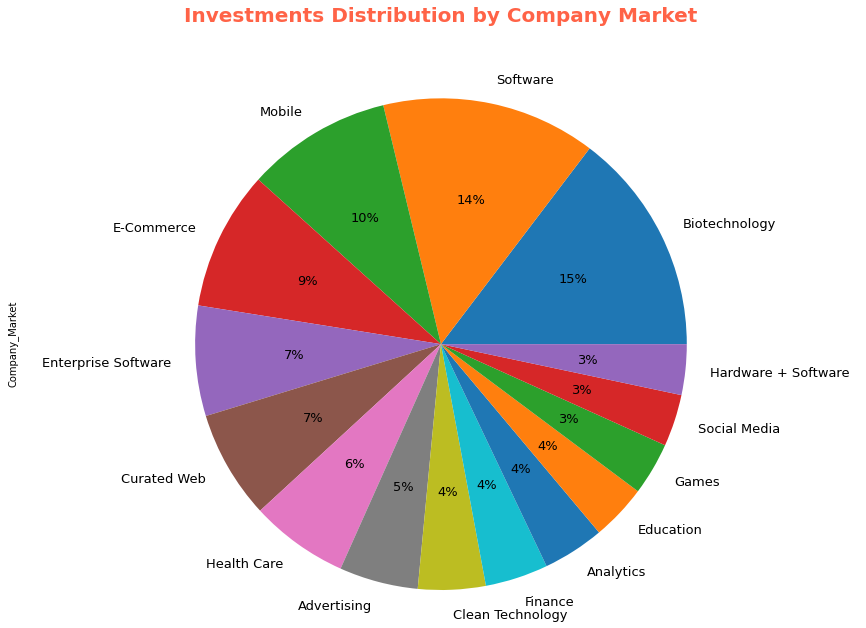

In [431]:
def plot_company_market_distribution(num): 
    df_list[num].Company_Market.value_counts().head(15).plot.pie(figsize=(15,10),autopct='%1.0f%%',fontsize=13)
    plt.title('Investments Distribution by Company Market\n\n', fontsize=20, fontweight='bold',color='tomato')
    plt.axis('equal')

plot_company_market_distribution(4)

Graphs - number of edges
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]

In [281]:
# def get_in_out_nodes(g, investors:pd.DataFrame, company_name: pd.DataFrame):
#     """
#     Split degrees to companies and investors (inbound, outbound)
#     :param g: graph
#     :param investors: investors DF
#     :param company_name: comapnies DF
#     """
#     all_degrees = g.degree
#     in_nodes = defaultdict(int)
#     out_nodes = defaultdict(int)

#     for company, n_edges in all_degrees:
#         if company in investors.values:
#             out_nodes[company] = n_edges
#         elif company in company_name.values:
#             in_nodes[company] = n_edges

#     print("Invested in companies (inbound)")
#     # print(dict(in_nodes))
#     print(in_nodes)
#     print("\n")
#     print("Investing companies (outbound)")
#     # print(dict(out_nodes))
#     print(out_nodes)
#     return in_nodes, out_nodes

# def avg_degree(nodes:dict):
#     """
#     Calculate the average degree of the nodes in the graph
#     :param nodes: dictionary of node_name(str): degree(int)
#     """
#     return sum([degree for degree in nodes.values()]) / len(nodes)

# g = graph_list[0]
# investing_companies = df_list[0]['Investor_Name']
# invested_companies = df_list[0]['Company_Name']
# inbound, outbound = get_in_out_nodes(g, investing_companies, invested_companies)
# print(avg_degree(inbound))
# print(avg_degree(outbound))


In [445]:
def build_centrality_table(num):    
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
    nodes = pd.DataFrame(list(G.nodes))
    #degree_centrality, in_degree_centrality, out_degree_centrality, betweenness_centrality and closeness_centrality
    measures = {'Degree': nx.degree_centrality,'In-Degree': nx.in_degree_centrality,'Out-Degree': nx.out_degree_centrality,'Betweenness': nx.betweenness_centrality,'Closeness': nx.closeness_centrality}

    for name, measure in measures.items():
        if name == 'Betweenness':
            centrality_dict = measure(G,k=min(len(G.nodes),2000))
        else:
            centrality_dict = measure(G)
        nodes[name] = nodes[0].apply(lambda x: centrality_dict.get(x, None))
    return nodes

In [446]:
centrality_table = build_centrality_table(3).rename(columns={0: "Company Name"})
centrality_table

,Company Name,Degree,In-Degree,Out-Degree,Betweenness,Closeness
0,3i Group,0.004492,0.000000,0.004492,0.0,0.000000
1,SiGe Semiconductor,0.000772,0.000772,0.000000,0.0,0.000772
2,Accel Partners,0.009194,0.000000,0.009194,0.0,0.000000
3,Tumri,0.000351,0.000351,0.000000,0.0,0.000351
4,Mu Dynamics,0.000281,0.000281,0.000000,0.0,0.000281
...,...,...,...,...,...,...
14245,payByMobile,0.000070,0.000070,0.000000,0.0,0.000070
14246,Digital Lumens,0.000070,0.000070,0.000000,0.0,0.000070
14247,Brian O'Kelley,0.000070,0.000000,0.000070,0.0,0.000000
14248,Edward Zimmerman,0.000070,0.000000,0.000070,0.0,0.000000


In [447]:
centrality_table.sort_values(['Degree'],ascending=False).head(10)[['Company Name','Degree']]

,Company Name,Degree
262,Intel Capital,0.013755
73,Draper Fisher Jurvetson (DFJ),0.012422
174,Sequoia Capital,0.012071
338,New Enterprise Associates,0.010948
2,Accel Partners,0.009194
298,Kleiner Perkins Caufield & Byers,0.007650
37,Benchmark,0.007509
798,Venrock,0.006246
613,U.S. Venture Partners,0.005685
370,Menlo Ventures,0.005685


In [448]:
centrality_table.sort_values(['In-Degree'],ascending=False).head(10)[['Company Name','In-Degree']]

,Company Name,In-Degree
5571,Texxi,0.001614
1846,EUSA Pharma,0.001614
9274,Lookery,0.001544
9998,Foodzie,0.001544
9306,Path101,0.001474
13856,SimpleGeo,0.001474
1272,Nanosolar,0.001474
7388,Twitter,0.001404
13770,Square,0.001333
11345,Milo,0.001333


In [449]:
centrality_table.sort_values(['Out-Degree'],ascending=False).head(10)[['Company Name','Out-Degree']]

,Company Name,Out-Degree
262,Intel Capital,0.013755
73,Draper Fisher Jurvetson (DFJ),0.012422
174,Sequoia Capital,0.012071
338,New Enterprise Associates,0.010948
2,Accel Partners,0.009194
298,Kleiner Perkins Caufield & Byers,0.007650
37,Benchmark,0.007509
798,Venrock,0.006246
613,U.S. Venture Partners,0.005685
370,Menlo Ventures,0.005685


In [450]:
centrality_table.sort_values(['Betweenness'],ascending=False).head(10)[['Company Name','Betweenness']]

,Company Name,Betweenness
7465,Copan Systems,5.264266e-07
7461,Emergent Game Technologies,4.211413e-07
1120,Ardian,2.105706e-07
2717,Inside Secure,1.052853e-07
792,Texas Instruments,1.052853e-07
9956,Sirigen,7.019021e-08
1267,Facebook,7.019021e-08
3898,Eons,3.509511e-08
9572,PureSense,0.000000e+00
9494,Hybio Pharmaceutical,0.000000e+00


In [451]:
centrality_table.sort_values(['Closeness'],ascending=False).head(10)[['Company Name','Closeness']]

,Company Name,Closeness
5571,Texxi,0.001614
1846,EUSA Pharma,0.001614
9274,Lookery,0.001581
9998,Foodzie,0.001544
9306,Path101,0.001474
13856,SimpleGeo,0.001474
1272,Nanosolar,0.001474
7388,Twitter,0.001404
11345,Milo,0.001333
13770,Square,0.001333


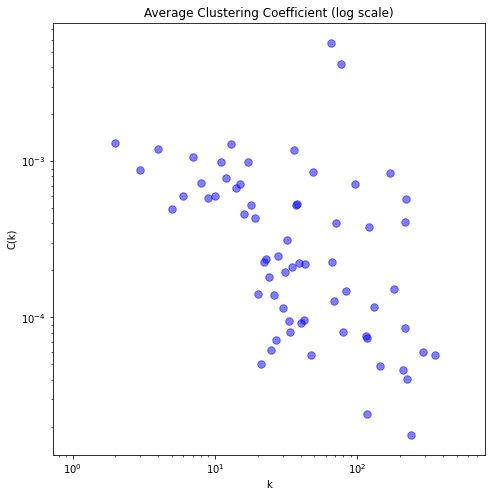

In [481]:
def plot_clustering_coefficient(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
    clustering_dict = defaultdict(list)
    for node in G.nodes():
        k = G.degree(node)
        clustering_dict[k].append(nx.clustering(G,node))
    k_list = sorted(clustering_dict.keys())
    clustering_list = []
    for k in k_list:
        clustering_list.append(np.mean(clustering_dict[k])) 
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_list,clustering_list,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average Clustering Coefficient (log scale)')
    # fig.savefig(f'plots/clustering_coefficient_{num}.png', bbox_inches='tight')
    plt.show()
    
plot_clustering_coefficient(4)

In [ ]:
def plot_weight_dist(G):
    weight_hist = list(nx.get_edge_attributes(G,'weight').values())
    weight_hist = np.array(weight_hist, dtype=float)
    degree_prob = weight_hist/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(5,5))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('w [log scale]')
    axes.set_ylabel('p(w) [log scale]')
    axes.set_title('Weight Distribution')
    
    plt.show()

In [488]:
# G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
G = graph_list[2]
print(np.array(nx.get_edge_attributes(G,'Raised_Amount_USD').values()))

dict_values([16000000.0, 8778321.0, 7761532.0, 7526768.0, 3602903.0, 27600000.0, 5527720.0, 3000000.0, 11000000.0, 10000000.0, 300000.0, 9000000.0, 15000000.0, 36000000.0, 3000000.0, 5300000.0, 10000000.0, 36000000.0, 120000000.0, 4200000.0, 9200000.0, 10000000.0, 19500000.0, 5000000.0, 13000000.0, 28000000.0, 16000000.0, 4600000.0, 8000000.0, 5000000.0, 3500000.0, 5000000.0, 3500000.0, 1000000.0, 1208424.0, 100000000.0, 300000.0, 10500000.0, 11000000.0, 5400000.0, 35000000.0, 10000000.0, 100000000.0, 40000000.0, 6000000.0, 10500000.0, 1000000.0, 5300000.0, 18800000.0, 13500000.0, 3000000.0, 12000000.0, 2000000.0, 6500000.0, 500000.0, 15000000.0, 300000.0, 9000000.0, 6500000.0, 50000000.0, 15000000.0, 23000000.0, 9300000.0, 16000000.0, 30000000.0, 5000000.0, 1500000.0, 5378509.0, 220000.0, 10000000.0, 2500000.0, 32640.0, 999396.0, 2420000.0, 500000.0, 4500000.0, 2420000.0, 4000000.0, 800000.0, 6000000.0, 2923307.0, 1000000.0, 500000.0, 3000000.0, 1000000.0, 30000000.0, 1500000.0, 20000

In [388]:
##############################################################
####################### Do Not Delete ########################
##############################################################

# # Make the gephi's files
# graph_list_for_attr = []
# for i,df in enumerate(df_list):
#     attr_dic = {x:y for x, y in zip(df['Company_Name'], df['Company_Market'])}
#     attr_dic_fixed = {x:'Investors' for x in df['Investor_Name']}
#     attr_dic_fixed.update(attr_dic)
#     graph = nx.from_pandas_edgelist(df,source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph())
#     nx.set_node_attributes(graph, attr_dic_fixed, name="Sector")
#     graph_list_for_attr.append(graph)
#     nx.write_gexf(graph, f"Gephi{i}.gexf")